Importing required libraries to predict acceleration using random forest, calculate RMSE (RootMeanSquaredError), and create plots to compare predicted and actual acceleration

In [806]:
import pandas as pd
import numpy as np
import FileProcessing
import ModelClass

In [807]:
import random
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow
from tensorflow.keras import layers


class ModelClass():

    '''
    '''

    def define_neural_network(self, input):

        #input = keras.Input(shape=(18,))
        input = keras.Input(shape=(5,))
        # Fully connected layers
        x = layers.Dense(128, activation='relu')(input)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dense(16, activation='relu')(x)
        # Softmax used for classifier problems
        outputs = layers.Dense(1, activation="softmax")(x)

        model = keras.Model(inputs=input, outputs=outputs)
        model.compile(optimizer='rmsprop',
                      loss='mean_squared_error',
                      metrics=['mean_squared_error'])
        model.summary()

        return model

    def fit_neural_network(self, model, X_train, y_train):
        model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=1)
        return model

    def create_prediction_pair(self, df, n):
        '''
        create the prediction pair by shifting the actual data up by the mentioned number(0.1*n seconds) to create the timeseries info
        '''

        df["nextframeAcc"] = df.groupby(
            ["L-F_Pair"], as_index=False)["v_Acc"].shift(-1*n)
        df["nextframesvel"] = df.groupby(
            ["L-F_Pair"], as_index=False)["v_Vel"].shift(-1*n)
        df["nextframeposition"] = df.groupby(
            ["L-F_Pair"], as_index=False)["Local_Y"].shift(-1*n)
        df['nextframeposition'] = df['nextframeposition'].fillna(0)
        df['nextframesvel'] = df['nextframesvel'].fillna(0)
        df['nextframeAcc'] = df['nextframeAcc'].fillna(0)

        return df

    def test_train_pairs(self, df, split, seed):
        '''
        Read the input file into a dataframe.
        Input: File name for the file present in Data folder.
        Output: Dataframe name.
        '''
        random.seed(seed)
        df = df.applymap(lambda x: float(round(x, 4))
                         if isinstance(x, (int, float)) else x)
        total_pairs = df["L-F_Pair"].unique()
        total_pairs = total_pairs.tolist()
        test_split_cnt = round(len(total_pairs)*split)
        test_split_pairs = random.sample(total_pairs, test_split_cnt)
        train_df = df[df['L-F_Pair'].isin(test_split_pairs)]
        test_df = df[~df['L-F_Pair'].isin(test_split_pairs)]

        return train_df, test_df

    def prediction_test_pairs(self, df, pair_from, pair_to):
        unique_pairs_values = df['L-F_Pair'].unique()
        unique_pairs_list = unique_pairs_values.tolist()
        unique_pairs_df = unique_pairs_list[pair_from:pair_to]
        return unique_pairs_df

    def feature_selection(self, train_df, test_df):
        X_train = train_df[['Rear_to_Front_Space_Headway', 'Vehicle_combination_cat',
                            'Local_Y', 'Velocity Difference_Following-Preceding', 'v_Vel']]

        X_test = test_df[['Rear_to_Front_Space_Headway', 'Vehicle_combination_cat',
                          'Local_Y', 'Velocity Difference_Following-Preceding', 'v_Vel']]

        #X_train = train_df.drop(['v_Acc', 'L-F_Pair'], axis=1)
        y_train = train_df['nextframeAcc']
        #X_test = test_df.drop(['v_Acc', 'L-F_Pair'], axis=1)
        y_test = test_df['nextframeAcc']

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        return X_train, y_train, X_test, y_test

    

Loading the cleaned ngsim data using pandas

In [808]:
fileProcessing=FileProcessing.FileProcessing()

In [809]:
#model_obj=ModelClass.ModelClass()
model_obj=ModelClass()

In [810]:
file_name='Cleaned_NGSIM_Data'
ngsim=fileProcessing.read_input(file_name)

original File path: c:\Users\StudentAccount\Python\Capstone\gitcodelocation\DataDrivenCarFollowing\datadrivencarfollowing-v1\scripts
Data File path: c:\Users\StudentAccount\Python\Capstone\gitcodelocation\DataDrivenCarFollowing\datadrivencarfollowing-v1\data


Adding new columns nextframe acceleration, velocity, and position which will be our target features.

In [811]:

#ngsim=model_obj.create_prediction_pair(ngsim,1)
#ngsim=model_obj.create_prediction_pair(ngsim,1)
model_obj.create_prediction_pair(ngsim,1)

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Class,v_Vel,...,lane_changes,Prec_Vehicle_ID,previous_Vehicle_Velocity,previous_Vehicle_Acceleration,previous_car_lane_changes,pair_Time_Duration,total_pair_duration,nextframeAcc,nextframesvel,nextframeposition
0,22,37,1118846982600,15.099,34.445,6451138.033,1873346.572,5.02920,2,9.424416,...,False,22,0.0,0.0,False,0.0,41.6,0.000000,9.424416,37.945
1,22,38,1118846982700,15.082,37.945,6451140.385,1873343.980,5.02920,2,9.424416,...,False,22,0.0,0.0,False,0.1,41.6,0.000000,9.424416,41.445
2,22,39,1118846982800,15.063,41.445,6451142.738,1873341.389,5.02920,2,9.424416,...,False,22,0.0,0.0,False,0.2,41.6,0.000000,9.424416,44.446
3,22,40,1118846982900,15.049,44.446,6451144.754,1873339.167,5.02920,2,9.424416,...,False,22,0.0,0.0,False,0.3,41.6,0.000000,9.424416,47.946
4,22,41,1118846983000,15.030,47.946,6451147.107,1873336.576,5.02920,2,9.424416,...,False,22,0.0,0.0,False,0.4,41.6,-2.511552,9.424416,50.952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444316,2486,11094,1113438674300,18.097,1605.419,6042625.418,2134660.086,4.96824,2,1.740408,...,False,2486,0.0,0.0,False,168.9,169.3,1.432560,1.798320,1605.960
444317,2486,11095,1113438674400,18.100,1605.960,6042625.342,2134660.579,4.96824,2,1.798320,...,False,2486,0.0,0.0,False,169.0,169.3,0.862584,1.889760,1606.582
444318,2486,11096,1113438674500,18.104,1606.582,6042625.243,2134661.224,4.96824,2,1.889760,...,False,2486,0.0,0.0,False,169.1,169.3,-0.871728,1.889760,1607.253
444319,2486,11097,1113438674600,18.109,1607.253,6042625.137,2134661.914,4.96824,2,1.889760,...,False,2486,0.0,0.0,False,169.2,169.3,-1.341120,1.804416,1607.873


In [812]:
ngsim["Vehicle_combination_cat"] = ngsim["Vehicle_combination"].astype("category").cat.codes
ngsim["Preceding_Vehicle_Class_cat"]=ngsim["Preceding_Vehicle_Class"].astype("category").cat.codes
ngsim["Location_cat"]=ngsim["Location"].astype("category").cat.codes
                                          

Spliting data into 70% training and 30% testing

In [813]:
train_df, test_df=model_obj.test_train_pairs(ngsim,0.7,2100)

In [814]:
drop_columns_list=['Vehicle_ID','Frame_ID','Global_Time','Local_X','Global_X','Global_Y','v_length','Lane_ID','Preceding','Space_Headway','Time_Headway','v_Class_Name','lane_changes','previous_car_lane_changes','Prec_Vehicle_ID','Vehicle_combination','Preceding_Vehicle_Class','Location','Relative_Time']

In [815]:
train_df=train_df.drop(drop_columns_list,axis=1,errors='ignore')
test_df=test_df.drop(drop_columns_list,axis=1,errors='ignore')

In [816]:
print(train_df.isnull().sum())

Local_Y                                        0
v_Class                                        0
v_Vel                                          0
v_Acc                                          0
Rear_to_Front_Space_Headway                    0
Front_To_Rear_Time_Headway                     0
Velocity Difference_Following-Preceding        0
Acceleration Difference_Following-Preceding    0
L-F_Pair                                       0
preceding_vehicle_length                       0
previous_Vehicle_Velocity                      0
previous_Vehicle_Acceleration                  0
pair_Time_Duration                             0
total_pair_duration                            0
nextframeAcc                                   0
nextframesvel                                  0
nextframeposition                              0
Vehicle_combination_cat                        0
Preceding_Vehicle_Class_cat                    0
Location_cat                                   0
dtype: int64


In [817]:
train_df.dtypes

Local_Y                                        float64
v_Class                                        float64
v_Vel                                          float64
v_Acc                                          float64
Rear_to_Front_Space_Headway                    float64
Front_To_Rear_Time_Headway                     float64
Velocity Difference_Following-Preceding        float64
Acceleration Difference_Following-Preceding    float64
L-F_Pair                                        object
preceding_vehicle_length                       float64
previous_Vehicle_Velocity                      float64
previous_Vehicle_Acceleration                  float64
pair_Time_Duration                             float64
total_pair_duration                            float64
nextframeAcc                                   float64
nextframesvel                                  float64
nextframeposition                              float64
Vehicle_combination_cat                        float64
Preceding_

In [818]:
print(test_df.isnull().sum())

Local_Y                                        0
v_Class                                        0
v_Vel                                          0
v_Acc                                          0
Rear_to_Front_Space_Headway                    0
Front_To_Rear_Time_Headway                     0
Velocity Difference_Following-Preceding        0
Acceleration Difference_Following-Preceding    0
L-F_Pair                                       0
preceding_vehicle_length                       0
previous_Vehicle_Velocity                      0
previous_Vehicle_Acceleration                  0
pair_Time_Duration                             0
total_pair_duration                            0
nextframeAcc                                   0
nextframesvel                                  0
nextframeposition                              0
Vehicle_combination_cat                        0
Preceding_Vehicle_Class_cat                    0
Location_cat                                   0
dtype: int64


In [819]:
test_df

,Local_Y,v_Class,v_Vel,v_Acc,Rear_to_Front_Space_Headway,Front_To_Rear_Time_Headway,Velocity Difference_Following-Preceding,Acceleration Difference_Following-Preceding,L-F_Pair,preceding_vehicle_length,previous_Vehicle_Velocity,previous_Vehicle_Acceleration,pair_Time_Duration,total_pair_duration,nextframeAcc,nextframesvel,nextframeposition,Vehicle_combination_cat,Preceding_Vehicle_Class_cat,Location_cat
0,34.445,2.0,9.4244,0.0000,12.4897,1.3252,9.4244,0.0000,13-22,4.5212,0.0000,0.0000,0.0,41.6,0.0000,9.4244,37.945,0.0,0.0,1.0
1,37.945,2.0,9.4244,0.0000,12.4562,1.3217,9.4244,0.0000,13-22,4.5212,0.0000,0.0000,0.1,41.6,0.0000,9.4244,41.445,0.0,0.0,1.0
2,41.445,2.0,9.4244,0.0000,12.4318,1.3191,9.4244,0.0000,13-22,4.5212,0.0000,0.0000,0.2,41.6,0.0000,9.4244,44.446,0.0,0.0,1.0
3,44.446,2.0,9.4244,0.0000,12.5781,1.3346,9.4244,0.0000,13-22,4.5212,0.0000,0.0000,0.3,41.6,0.0000,9.4244,47.946,0.0,0.0,1.0
4,47.946,2.0,9.4244,0.0000,12.5842,1.3353,9.4244,0.0000,13-22,4.5212,0.0000,0.0000,0.4,41.6,-2.5116,9.4244,50.952,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443695,1545.483,2.0,10.1895,0.7102,19.7703,1.9403,2.4536,-0.6980,2469-2472,4.8666,7.7358,1.4082,37.4,37.8,-0.0945,10.2321,1548.859,0.0,0.0,0.0
443697,1548.859,2.0,10.2321,-0.0945,19.9136,1.9462,2.2037,-3.5082,2469-2472,4.8666,8.0284,3.4138,37.5,37.8,-0.0549,10.2260,1552.214,0.0,0.0,0.0
443700,1552.214,2.0,10.2260,-0.0549,20.0569,1.9614,1.6673,-3.4686,2469-2472,4.8666,8.5588,3.4138,37.6,37.8,0.0000,10.2199,1555.566,0.0,0.0,0.0
443701,1555.566,2.0,10.2199,0.0000,20.1026,1.9670,0.9418,-3.4138,2469-2472,4.8666,9.2781,3.4138,37.7,37.8,0.0000,10.2230,1558.919,0.0,0.0,0.0


In [820]:
train_df["Front_To_Rear_Time_Headway"] = train_df["Front_To_Rear_Time_Headway"].replace(np.inf, 999)
train_df[train_df.select_dtypes(np.float64).columns]=train_df.select_dtypes(np.float64).astype(np.float32)

In [821]:
train_df.dtypes

Local_Y                                        float32
v_Class                                        float32
v_Vel                                          float32
v_Acc                                          float32
Rear_to_Front_Space_Headway                    float32
Front_To_Rear_Time_Headway                     float32
Velocity Difference_Following-Preceding        float32
Acceleration Difference_Following-Preceding    float32
L-F_Pair                                        object
preceding_vehicle_length                       float32
previous_Vehicle_Velocity                      float32
previous_Vehicle_Acceleration                  float32
pair_Time_Duration                             float32
total_pair_duration                            float32
nextframeAcc                                   float32
nextframesvel                                  float32
nextframeposition                              float32
Vehicle_combination_cat                        float32
Preceding_

In [822]:
print(np.isnan(train_df.any())) #and gets False)
print(np.isfinite(train_df.all())) #and gets True)

Local_Y                                        False
v_Class                                        False
v_Vel                                          False
v_Acc                                          False
Rear_to_Front_Space_Headway                    False
Front_To_Rear_Time_Headway                     False
Velocity Difference_Following-Preceding        False
Acceleration Difference_Following-Preceding    False
L-F_Pair                                       False
preceding_vehicle_length                       False
previous_Vehicle_Velocity                      False
previous_Vehicle_Acceleration                  False
pair_Time_Duration                             False
total_pair_duration                            False
nextframeAcc                                   False
nextframesvel                                  False
nextframeposition                              False
Vehicle_combination_cat                        False
Preceding_Vehicle_Class_cat                   

In [823]:
#train_df = np.nan_to_num(train_df)


In [824]:
train_df

,Local_Y,v_Class,v_Vel,v_Acc,Rear_to_Front_Space_Headway,Front_To_Rear_Time_Headway,Velocity Difference_Following-Preceding,Acceleration Difference_Following-Preceding,L-F_Pair,preceding_vehicle_length,previous_Vehicle_Velocity,previous_Vehicle_Acceleration,pair_Time_Duration,total_pair_duration,nextframeAcc,nextframesvel,nextframeposition,Vehicle_combination_cat,Preceding_Vehicle_Class_cat,Location_cat
15,34.973999,2.0,10.5948,0.0000,14.2616,1.3461,10.5948,0.0000,351-364,4.8768,0.0,0.0,0.000000,48.400002,0.0000,10.5948,38.473999,0.0,0.0,1.0
16,38.473999,2.0,10.5948,0.0000,14.1000,1.3308,10.5948,0.0000,351-364,4.8768,0.0,0.0,0.100000,48.400002,0.0000,10.5948,41.973999,0.0,0.0,1.0
17,41.973999,2.0,10.5948,0.0000,13.9507,1.3167,10.5948,0.0000,351-364,4.8768,0.0,0.0,0.200000,48.400002,0.0000,10.5948,44.973999,0.0,0.0,1.0
18,44.973999,2.0,10.5948,0.0000,13.9507,1.3167,10.5948,0.0000,351-364,4.8768,0.0,0.0,0.300000,48.400002,0.0000,10.5948,48.474998,0.0,0.0,1.0
19,48.474998,2.0,10.5948,0.0000,13.7983,1.3024,10.5948,0.0000,351-364,4.8768,0.0,0.0,0.400000,48.400002,1.5027,10.5948,51.935001,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444316,1605.418945,2.0,1.7404,0.0732,5.3127,3.0525,1.7404,0.0732,2478-2486,4.5110,0.0,0.0,168.899994,169.300003,1.4326,1.7983,1605.959961,0.0,0.0,0.0
444317,1605.959961,2.0,1.7983,1.4326,5.2639,2.9271,1.7983,1.4326,2478-2486,4.5110,0.0,0.0,169.000000,169.300003,0.8626,1.8898,1606.582031,0.0,0.0,0.0
444318,1606.582031,2.0,1.8898,0.8626,5.1938,2.7484,1.8898,0.8626,2478-2486,4.5110,0.0,0.0,169.100006,169.300003,-0.8717,1.8898,1607.253052,0.0,0.0,0.0
444319,1607.253052,2.0,1.8898,-0.8717,5.1389,2.7194,1.8898,-0.8717,2478-2486,4.5110,0.0,0.0,169.199997,169.300003,-1.3411,1.8044,1607.873047,0.0,0.0,0.0


In [825]:
#train_df = train_df.applymap(lambda x: float(round(x, 2)) if isinstance(x, (int, float)) else x)
#train_df

In [826]:
#from numpy import inf
#train_df[train_df == inf] = np.finfo(np.float32).max

In [827]:
X_train,y_train,X_test,y_test= model_obj.feature_selection(train_df,test_df)

In [828]:
model=model_obj.define_neural_network(X_train)

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
dense_69 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_70 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_71 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 17        
Total params: 10,081
Trainable params: 10,081
Non-trainable params: 0
_________________________________________________________________


In [829]:
model=model_obj.fit_neural_network(model,X_train,y_train)

9914/9914 [==============================] - 7s 722us/step - loss: 3.1203 - mean_squared_error: 3.1203


In [830]:
predict_on_pair=model_obj.prediction_test_pairs(test_df,100,102)
predict_on_pair

['2871-2876', '2856-2862']

In [831]:
test_df[test_df['L-F_Pair'].isin(predict_on_pair)]

,Local_Y,v_Class,v_Vel,v_Acc,Rear_to_Front_Space_Headway,Front_To_Rear_Time_Headway,Velocity Difference_Following-Preceding,Acceleration Difference_Following-Preceding,L-F_Pair,preceding_vehicle_length,previous_Vehicle_Velocity,previous_Vehicle_Acceleration,pair_Time_Duration,total_pair_duration,nextframeAcc,nextframesvel,nextframeposition,Vehicle_combination_cat,Preceding_Vehicle_Class_cat,Location_cat
57023,35.424,2.0,11.8049,0.0000,19.7663,1.6744,11.8049,0.0000,2871-2876,3.9624,0.0000,0.0000,0.0,68.7,0.0000,11.8049,39.425,0.0,0.0,1.0
57077,39.425,2.0,11.8049,0.0000,19.6108,1.6612,11.8049,0.0000,2871-2876,3.9624,0.0000,0.0000,0.1,68.7,0.0000,11.8049,43.424,0.0,0.0,1.0
57184,43.424,2.0,11.8049,0.0000,19.4554,1.6481,11.8049,0.0000,2871-2876,3.9624,0.0000,0.0000,0.2,68.7,0.0000,11.8049,47.424,0.0,0.0,1.0
57283,47.424,2.0,11.8049,0.0000,19.3030,1.6352,11.8049,0.0000,2871-2876,3.9624,0.0000,0.0000,0.3,68.7,0.0000,11.8049,50.924,0.0,0.0,1.0
57369,50.924,2.0,11.8049,0.0000,19.3030,1.6352,11.8049,0.0000,2871-2876,3.9624,0.0000,0.0000,0.4,68.7,1.2253,11.8049,54.938,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124657,1268.701,2.0,3.5143,0.0000,13.6307,3.8786,-1.1125,-0.8077,2871-2876,3.9624,4.6269,0.8077,68.3,68.7,0.0000,3.5143,1269.854,0.0,0.0,1.0
124725,1269.854,2.0,3.5143,0.0000,14.2524,4.0555,-1.2558,-2.0086,2871-2876,3.9624,4.7701,2.0086,68.4,68.7,0.0000,3.5143,1271.008,0.0,0.0,1.0
124828,1271.008,2.0,3.5143,0.0000,14.9078,4.2420,-1.5179,-3.3040,2871-2876,3.9624,5.0322,3.3040,68.5,68.7,-0.1067,3.5082,1272.163,0.0,0.0,1.0
124908,1272.163,2.0,3.5082,-0.1067,15.6088,4.4492,-1.8837,-3.5204,2871-2876,3.9624,5.3919,3.4138,68.6,68.7,0.0945,3.5113,1273.307,0.0,0.0,1.0


In [832]:

def model_prediction( test_df, unique_pairs_df, target_variable, model, time_frame):
    '''
    predicton using randome forest model using loops
    '''
    predicted_df = []
    # r = [] Not used
    input_df = pd.DataFrame()

    for i in unique_pairs_df:
        # input_df this is the input data frame
        input_df = test_df[test_df['L-F_Pair'] == i]
        print(f"input_df:{input_df}")
        velocity_of_subject_vehicle = np.zeros(input_df.shape[0])
        Vehicle_combination = np.zeros(input_df.shape[0])
        Local_Y_of_subject_vehicle = np.zeros(input_df.shape[0])
        rear_to_front_spacing = np.zeros(input_df.shape[0])
        differnce_of_preciding_and_following_velocity = np.zeros(
            input_df.shape[0])

        predicted_acceleration = np.zeros(input_df.shape[0])

        # adding first value of the vehicle
        velocity_of_subject_vehicle[0] = input_df.iloc[0]['v_Vel']
        rear_to_front_spacing[0] = input_df.iloc[0]['Rear_to_Front_Space_Headway']
        Vehicle_combination[0] = input_df.iloc[0]['Vehicle_combination_cat']
        Local_Y_of_subject_vehicle[0] = input_df.iloc[0]['Local_Y']
        differnce_of_preciding_and_following_velocity[0] = input_df.iloc[
            0]['Velocity Difference_Following-Preceding']

        predicted_acceleration[0] = input_df.iloc[1][target_variable]

    #       #predicting first value of acceleration
        # check here
        input_df[1]['predicted_acceleration']=model.predict(np.array(
        #predicted_acceleration[1] = model.predict(np.array(
            [velocity_of_subject_vehicle[0], Vehicle_combination[0], Local_Y_of_subject_vehicle[0], differnce_of_preciding_and_following_velocity[0], rear_to_front_spacing[0]]).reshape(1, -1))

    #     #calculating speed from the predicted acceleration.
        # check here

        for j in range(2, len(input_df)):

            input_df[j]['predicted_velocity'] = input_df[j-1]['predicted_velocity']+(input_df[j]['predicted_acceleration'] * time_frame)
            differnce_of_preciding_and_following_velocity[j] = input_df[j]['predicted_velocity'] - \
                input_df.iloc[j]['previous_Vehicle_Velocity']
            # rear_to_front_spacing[j] = rear_to_front_spacing[j-1]+((velocity_of_subject_vehicle[j-1]*0.1)+ (0.5*predicted_acceleration[j]*pow(0.1,2)))
            rear_to_front_spacing[j] = velocityinput_df_of_subject_vehicle[j-1]['predicted_velocity'] * \
                time_frame + (0.5*input_df[j]['predicted_acceleration']*pow(time_frame, 2))
            Local_Y_of_subject_vehicle[j] = Local_Y_of_subject_vehicle[j-1]
            Vehicle_combination[j] = Vehicle_combination[j-1]

            if j == len(input_df)-1:
                break
            predicted_acceleration[j+1]['predicted_acceleration'] = model.predict(np.array(
                [Vehicle_combination[j], Local_Y_of_subject_vehicle[j], velocity_of_subject_vehicle[j], differnce_of_preciding_and_following_velocity[j], rear_to_front_spacing[j]]).reshape(1, -1))

    #input_df['predicted_acceleration'] = predicted_acceleration
    #input_df['predicted_velocity'] = velocity_of_subject_vehicle

    predicted_df.append(input_df)
    result = pd.concat(predicted_df)
    return result


In [833]:
target_variable = 'nextframeAcc'
predicted_data = model_prediction(test_df, predict_on_pair, target_variable, model,0.1)

input_df:         Local_Y  v_Class    v_Vel   v_Acc  Rear_to_Front_Space_Headway  \
57023     35.424      2.0  11.8049  0.0000                      19.7663   
57077     39.425      2.0  11.8049  0.0000                      19.6108   
57184     43.424      2.0  11.8049  0.0000                      19.4554   
57283     47.424      2.0  11.8049  0.0000                      19.3030   
57369     50.924      2.0  11.8049  0.0000                      19.3030   
...          ...      ...      ...     ...                          ...   
124657  1268.701      2.0   3.5143  0.0000                      13.6307   
124725  1269.854      2.0   3.5143  0.0000                      14.2524   
124828  1271.008      2.0   3.5143  0.0000                      14.9078   
124908  1272.163      2.0   3.5082 -0.1067                      15.6088   
124975  1273.307      2.0   3.5113  0.0945                      16.3251   

        Front_To_Rear_Time_Headway  Velocity Difference_Following-Preceding  \
57023      

KeyError: 1

In [ ]:
predicted_data

,Local_Y,v_Class,v_Vel,v_Acc,Rear_to_Front_Space_Headway,Front_To_Rear_Time_Headway,Velocity Difference_Following-Preceding,Acceleration Difference_Following-Preceding,L-F_Pair,preceding_vehicle_length,...,pair_Time_Duration,total_pair_duration,nextframeAcc,nextframesvel,nextframeposition,Vehicle_combination_cat,Preceding_Vehicle_Class_cat,Location_cat,predicted_acceleration,predicted_velocity
57906,33.044,2.0,10.2687,0.0000,12.9845,1.2645,10.2687,0.0000,2856-2862,3.6576,...,0.0,63.9,0.0000,10.2687,36.544,0.0,0.0,1.0,0.0,10.2687
58036,36.544,2.0,10.2687,0.0000,12.6980,1.2366,10.2687,0.0000,2856-2862,3.6576,...,0.1,63.9,0.0000,10.2687,40.044,0.0,0.0,1.0,1.0,0.0000
58046,40.044,2.0,10.2687,0.0000,12.3444,1.2021,10.2687,0.0000,2856-2862,3.6576,...,0.2,63.9,0.0000,10.2687,43.544,0.0,0.0,1.0,0.0,0.0000
58217,43.544,2.0,10.2687,0.0000,11.9725,1.1659,10.2687,0.0000,2856-2862,3.6576,...,0.3,63.9,0.0000,10.2687,47.044,0.0,0.0,1.0,1.0,0.1000
58288,47.044,2.0,10.2687,0.0000,11.6495,1.1345,10.2687,0.0000,2856-2862,3.6576,...,0.4,63.9,-3.2431,10.2687,50.515,0.0,0.0,1.0,1.0,0.2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114903,1294.419,2.0,16.7061,0.2957,21.5158,1.2879,4.4257,-0.8108,2856-2862,3.6576,...,63.5,63.9,-0.7437,16.6939,1299.929,0.0,0.0,1.0,1.0,63.3000
115003,1299.929,2.0,16.6939,-0.7437,21.6042,1.2941,4.2885,-2.3134,2856-2862,3.6576,...,63.6,63.9,-0.4206,16.6512,1305.389,0.0,0.0,1.0,1.0,63.4000
115104,1305.389,2.0,16.6512,-0.4206,21.7505,1.3062,4.1148,-1.7221,2856-2862,3.6576,...,63.7,63.9,0.3444,16.6451,1310.830,0.0,0.0,1.0,1.0,63.5000
115197,1310.830,2.0,16.6451,0.3444,21.9212,1.3170,4.0020,-0.3383,2856-2862,3.6576,...,63.8,63.9,0.7193,16.6848,1316.286,0.0,0.0,1.0,1.0,63.6000


In [ ]:
prediction1 = predicted_data[predicted_data["L-F_Pair"]=="2871-2876"]
prediction1

,Local_Y,v_Class,v_Vel,v_Acc,Rear_to_Front_Space_Headway,Front_To_Rear_Time_Headway,Velocity Difference_Following-Preceding,Acceleration Difference_Following-Preceding,L-F_Pair,preceding_vehicle_length,...,pair_Time_Duration,total_pair_duration,nextframeAcc,nextframesvel,nextframeposition,Vehicle_combination_cat,Preceding_Vehicle_Class_cat,Location_cat,predicted_acceleration,predicted_velocity


KeyError: 'pacc'

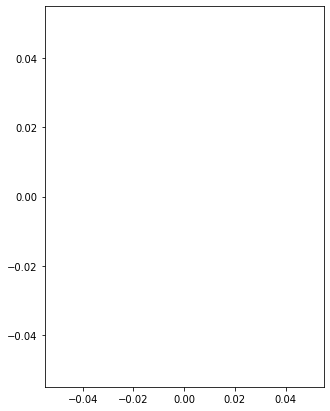

In [ ]:
#import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 7))


ax = plt.plot(prediction1["pair_Time_Duration"], prediction1["nextframeAcc"], color="r", label="Actual Value")
plt.plot(prediction1["pair_Time_Duration"], prediction1["pacc"], color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [ ]:
plt.figure(figsize=(5, 7))


ax = sns.lineplot(x=prediction1["pair_Time_Duration"], y = prediction1["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=prediction1["pair_Time_Duration"], y =prediction1["pacc"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

NameError: name 'plt' is not defined

In [ ]:
ngsim.columns

Index(['Vehicle_ID', 'Frame_ID', 'Global_Time', 'Local_X', 'Local_Y',
       'Global_X', 'Global_Y', 'v_length', 'v_Class', 'v_Vel', 'v_Acc',
       'Lane_ID', 'Preceding', 'Space_Headway', 'Time_Headway', 'Location',
       'Preceding_Vehicle_Class', 'Rear_to_Front_Space_Headway',
       'Front_To_Rear_Time_Headway', 'Velocity Difference_Following-Preceding',
       'Acceleration Difference_Following-Preceding', 'L-F_Pair',
       'v_Class_Name', 'Relative_Time', 'Vehicle_combination',
       'preceding_vehicle_length', 'lane_changes', 'Prec_Vehicle_ID',
       'previous_Vehicle_Velocity', 'previous_Vehicle_Acceleration',
       'previous_car_lane_changes', 'pair_Time_Duration',
       'total_pair_duration', 'nextframeAcc', 'nextframesvel',
       'nextframeposition', 'Vehicle_combination_cat',
       'Preceding_Vehicle_Class_cat', 'Location_cat'],
      dtype='object')

: 